# Dynamic graph - Lyon school data

This was originally written by Ian Gallagher: https://github.com/iggallagher

For this to you'll need to download the data and set your own data path. 

In [47]:
path = '/home/ag16115/Documents/phd/codebase_data/'

In [109]:
# path = ''

In [48]:
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import svds
from scipy import linalg
import matplotlib.pyplot as plt

In [49]:
import relastat as rs

In [50]:
data = pd.read_csv(path + 'ia-primary-school-proximity-attr.edges',
                   sep=',', on_bad_lines='skip', header=None)

In [51]:
data.head()

,0,1,2,3,4
0,1558,1567,31220,3B,3B
1,1560,1570,31220,3B,3B
2,1567,1574,31220,3B,3B
3,1632,1818,31220,4B,4B
4,1632,1866,31220,4B,4B


Rename the columns and sort out the time column. Currently there is an error where if the time column has an integer `rs.select()` won't run this needs sorting

In [52]:
data.columns = ['V1', 'V2', 'T', 'L1', 'L2']
data['H'] = [int(int(t)/(60*60)) for t in list(data['T'])]
data['D'] = [int(int(t)/(60*60*24)) for t in list(data['T'])]
data['T1'] = [str(10*int(i/24) + i%24 - 8) for i in list(data['H'])]

In [9]:
data.head()

,V1,V2,T,L1,L2,H,D,T1
0,1558,1567,31220,3B,3B,8,0,0
1,1560,1570,31220,3B,3B,8,0,0
2,1567,1574,31220,3B,3B,8,0,0
3,1632,1818,31220,4B,4B,8,0,0
4,1632,1866,31220,4B,4B,8,0,0


In [81]:
id_dict = {}
for i in range(len(data)):  
    if data['V1'][i] not in id_dict:
        id_dict[data['V1'][i]] = data['L1'][i]
    if data['V2'][i] not in id_dict:
        id_dict[data['V2'][i]] = data['L2'][i]

Make the adjacency matrix and attribute lists

In [55]:
A, attributes = rs.matrix_from_tables(data, ['V1', 'V2'], dynamic_col='T1', join_token='::')

['V1', 'V2']


In [56]:
def scree_plot(A, k = 50, s = 10, vline=None):
    UA, SA, VAt = svds(A,k=k)
    fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
    plt.scatter(range(len(SA)), np.sort(SA)[::-1], s =s)
    if vline:
        plt.axvline(x=vline, color='green', linewidth=0.5)

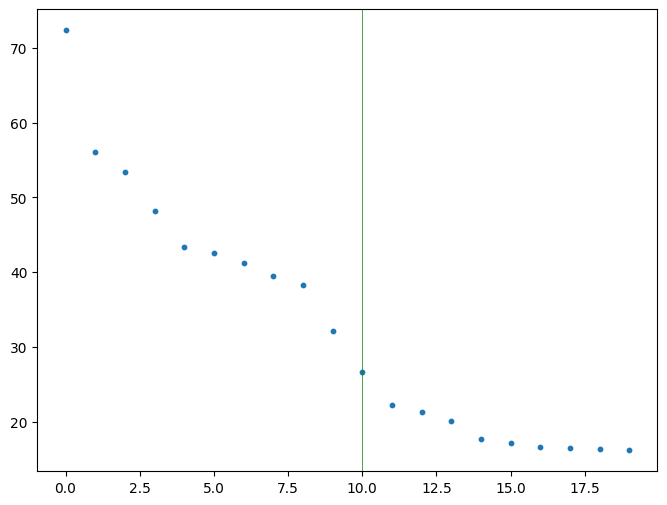

In [57]:
d = 10
scree_plot(A, k = 20,s = d, vline=10)

In [104]:
d = 10
embedding = rs.embed(A, d = d, right_embedding=True)
LHS = embedding[0]  
RHS = embedding[1]  

LHS = rs.degree_correction(LHS)      
# RHS = rs.degree_correction(RHS)

/home/ag16115/.local/lib/python3.8/site-packages/relastat/embedding.py:202: UserWarning: Warning: More than one connected component in the graph.
  warnings.warn(


We can select the embedding for the first time point using `rs.select()`

In [105]:
embed_T0, attributes_T0 = rs.select(RHS, attributes[1], {'time': '0'})

Generate plotting colours and markers using the school class for each student, treating teachers as their own separate group

In [106]:
import matplotlib as mpl

colours = np.array(list(mpl.colors.TABLEAU_COLORS.keys())[0:6])
colours[5] = 'black'

Z_classes = np.array([{'1A': 0, '1B': 1, '2A': 2, '2B': 3, '3A': 4, '3B': 5, '4A': 6,
                     '4B': 7, '5A': 8, '5B': 9, 'Teachers': 10}[id_dict[node_id]] for node_id in id_dict])
Z_colours = np.array([colours[{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, 'T': 5}[
                     id_dict[node_id][0]]] for node_id in id_dict])
Z_markers = np.array([{'A': 'o', 'B':'^', 'e':'s'}[id_dict[node_id][1]] for node_id in id_dict])

Create legend key

In [107]:
fig = plt.figure()
handles = [plt.scatter([], [], color='tab:blue', marker='o', s=12, label='Class 1A'),
           plt.scatter([], [], color='tab:blue',
                       marker='^', s=12, label='Class 1B'),
           plt.scatter([], [], color='tab:orange',
                       marker='o', s=12, label='Class 2A'),
           plt.scatter([], [], color='tab:orange',
                       marker='^', s=12, label='Class 2B'),
           plt.scatter([], [], color='tab:green',
                       marker='o', s=12, label='Class 3A'),
           plt.scatter([], [], color='tab:green',
                       marker='^', s=12, label='Class 3B'),
           plt.scatter([], [], color='tab:red',
                       marker='o', s=12, label='Class 4A'),
           plt.scatter([], [], color='tab:red',
                       marker='^', s=12, label='Class 4B'),
           plt.scatter([], [], color='tab:purple',
                       marker='o', s=12, label='Class 5A'),
           plt.scatter([], [], color='tab:purple',
                       marker='^', s=12, label='Class 5B'),
           plt.scatter([], [], color='black', marker='s', s=12, label='Teacher')]
plt.close()

Plot the right hand side embedding

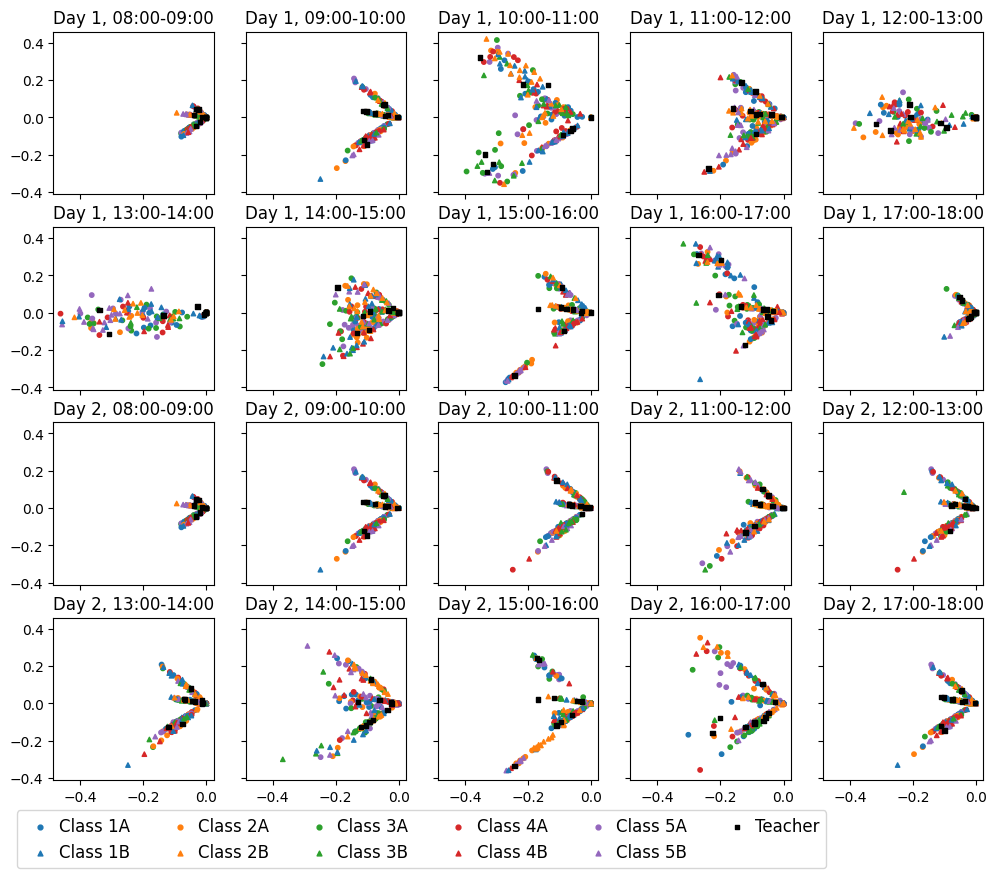

In [108]:
fig, axs = plt.subplots(4, 5, figsize=(12.0, 9.6), sharex=True, sharey=True)

T = len(data['T1'].unique())

for t in range(T):
    Y  = rs.select(RHS, attributes[1], {'time': str(t)})[0]
    i = int(t/5)
    j = t % 5
    for m in ('o','^','s'):
        idx = np.where(Z_markers == m)[0]
        axs[i, j].scatter(Y[idx, 0], Y[idx, 1],
                          marker=m, s=10, c=Z_colours[idx])

for t in range(T):
    i = int(t/5)
    j = t % 5
    axs[i, j].set_title('Day ' + str(int(t/10)+1) + ', ' + str(t % 10+8).zfill(2) +
                        ':00-' + str(t % 10+9).zfill(2) + ':00')

fig.legend(handles=handles, bbox_to_anchor=(0.432, 0), loc='lower center',
           ncol=6, fancybox=True, fontsize=12, handletextpad=0.1)
plt.subplots_adjust(bottom=0.10)